## Notebook for 18.065 Final Project on Cell Segmentation using Raman Spectra

In [286]:
# general python utility packages
import os
import platform
import random
import shutil
import sys
import time
import datetime
import functools
import itertools as it
import copy

# data science packages
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras as K
from sklearn.utils import resample
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import anndata as ann
import h5py


# plotting packages
import seaborn as sns

import matplotlib.pyplot as plt

# local imports
import preprocess as pp
import train 
import utils


# recommended Python3 version >= 3.5
print('Python version: {}'.format(platform.sys.version))


# progress bar
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm_notebook as tqdm


# required TensorFlow version >= 2.0.0
tf_version = tf.__version__
print('TensorFlow version: {}'.format(tf_version))
assert int(tf_version[0]) >= 2, "Tensorflow version must be >= 2.0"

# seed random numbers for reproducibility
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

print('\nImports Complete.')

Python version: 3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 22:05:27) 
[Clang 9.0.1 ]
TensorFlow version: 2.1.0

Imports Complete.


### Load datasets

In [287]:
# read in spatial dataframe
raman_df_full = pd.read_csv('data/raman_csv_files/final_spatial.csv')

KeyboardInterrupt: 

In [ ]:
print(f'Num NaN entries: {raman_df_full.pluripotent_cell.isnull().sum()}')

In [ ]:
# remove control image
c_mask = raman_df_full.image != 'control'
raman_df = raman_df_full[c_mask]

In [ ]:
# separate spectra from labels
raman_np = raman_df.iloc[:,10:].to_numpy()
labels = raman_df.iloc[:,:8]

In [ ]:
# pre-processing pipeline
raman_fp = pp.get_fingerprint_region(raman_np, start_ix=410)
print('finger-print region extracted')
raman_or = pp.remove_sharp_peaks_2d_iter(raman_fp, win_size=10, threshold=5)
print('sharp peaks removed')
raman_fr = pp.remove_fluorescence(raman_or, method='als')
print('fluorescence removed')
raman_hz = raman_fr - np.mean(raman_fr, axis=1, keepdims=True)
print('horizontal mean subtracted')
raman_ss = StandardScaler().fit_transform(raman_hz)
print('cell complete')

In [ ]:
# re-create raman_df
raman_df_pp = pp.to_dataframe(raman_ss, labels)

# remove extraneous null values
raman_df_pp = raman_df_pp[~raman_df_pp[0].isnull()]

In [213]:
raman_df_pp.shape, labels.shape, raman_ss.shape # looks good

((277694, 938), (277694, 8), (277694, 930))

In [214]:
# save everything in case we have to restart the kernel
pp_store = pd.HDFStore('prepocessed_data.h5')
pp_store['pp'] = raman_df_pp
pp_store.close()

/Users/tjamesso/miniconda3/envs/broad/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tjamesso/miniconda3/envs/broad/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_items] [items->None]

  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tjamesso/miniconda3/envs/broad/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3319: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['i

In [202]:
# load saved preprocessed data (because it takes forever to preprocess)
raman_df = pd.read_hdf('prepocessed_data.h5', key='pp')

In [203]:
# get background
bg_mask = raman_df.background == True
bg = raman_df[bg_mask]

In [204]:
# get foreground
fg = raman_df[~bg_mask]

# remove null values 
fg = fg[~fg.background.isnull()]

### Make training, validation, and test sets

In [205]:
# divide background spectra into train, test, val sets
train_bg_mask = bg.image.isin(['D13_Pos19', 'D11.5_Pos13'])
val_bg_mask = bg.image == 'D11_Pos4'
test_bg_mask = bg.image == 'D8_Pos4'

train_bg = bg[train_bg_mask]
val_bg = bg[val_bg_mask]
test_bg = bg[test_bg_mask]

In [ ]:
# reset random seed
import time
random.seed(time.time())
np.random.seed(time.time())
tf.random.set_seed(time.time())

In [206]:
# divide foreground spectra into train, test, val sets

# choose a random sampling of images to go in each set
fg_images = pd.Series(fg.image.unique())
train_im, test_im, val_im = np.split(fg_images, [int(len(fg_images)*.6), int(len(fg_images)*.8)])

# get dataframe with those images only
train_fg = fg[fg.image.isin(train_im)]
val_fg = fg[fg.image.isin(val_im)]
test_fg = fg[fg.image.isin(test_im)]

In [220]:
# DOWNSAMPLING
num_train_ds = train_bg.shape[0]
num_val_ds = val_bg.shape[0]
num_test_ds = test_bg.shape[0]

# randomly sample foreground to match number of background

train_fg_ds = resample(train_fg, n_samples=num_train_ds,
                       replace=False)
val_fg_ds = resample(val_fg, n_samples=num_val_ds,
                       replace=False)
test_fg_ds = resample(test_fg, n_samples=num_test_ds,
                       replace=False)

# make balanced train, val, and test sets
train_bal = pd.concat([train_fg_ds, train_bg])
val_bal= pd.concat([val_fg_ds, val_bg])
test_bal= pd.concat([test_fg_ds, test_bg])

In [225]:
total_samples = bg.shape[0]*2
print('Fraction of each train: {} val: {} test: {}'.format(train_bal.shape[0]/total_samples, val_bal.shape[0]/total_samples,  test_bal.shape[0]/total_samples))
train_bal.shape[0]/total_samples + val_bal.shape[0]/total_samples + test_bal.shape[0]/total_samples

Fraction of each train: 0.49570552147239266 val: 0.1705521472392638 test: 0.3337423312883436


1.0

In [7]:
# UPSAMPLING
# create balanced train, val, and test sets by upsampling bg spectra
# get num of samples in each fg set
num_train = train_fg.shape[0]
num_val = val_fg.shape[0]
num_test = test_fg.shape[0]

# upsample background to match number of foreground
train_bg_up = resample(train_bg, n_samples=num_train,
                       replace=True)
val_bg_up = resample(val_bg, n_samples=num_val,
                       replace=True)
test_bg_up = resample(test_bg, n_samples=num_test,
                       replace=True)

# make balanced train, val, and test sets
train_bal = pd.concat([train_fg, train_bg_up])
val_bal= pd.concat([val_fg, val_bg_up])
test_bal= pd.concat([test_fg, test_bg_up])

In [8]:
# check that train, val, and test sets all represent entire amount of data
total_samples = fg.shape[0]*2
print('Fraction of each train: {} val: {} test: {}'.format(train_bal.shape[0]/total_samples, val_bal.shape[0]/total_samples,  test_bal.shape[0]/total_samples))
train_bal.shape[0]/total_samples + val_bal.shape[0]/total_samples + test_bal.shape[0]/total_samples

Fraction of each train: 0.6296754585911213 val: 0.17652954158978254 test: 0.1937949998190962


1.0

In [226]:
# separate labels from raman spectra
sep_ix =8
train_bal_labels = train_bal.iloc[:, :sep_ix]
train_bal_values = train_bal.iloc[:, sep_ix:].to_numpy()

val_bal_labels = val_bal.iloc[:, :sep_ix]
val_bal_values = val_bal.iloc[:, sep_ix:].to_numpy()

test_bal_labels = test_bal.iloc[:, :sep_ix]
test_bal_values = test_bal.iloc[:, sep_ix:].to_numpy()

In [227]:
train_bal_labels

,image,day,pos,cell_id,pixel_id,pix_x,pix_y,background
162817,D10.5_Pos15,D10.5,Pos15,D10.5_Pos15_cell12,D10.5_Pos15_cell12_pix68,67.0,20.0,False
42101,D8.5_Pos12,D8.5,Pos12,D8.5_Pos12_cell3,D8.5_Pos12_cell3_pix31,85.0,82.0,False
26373,D10_Pos1,D10,Pos1,D10_Pos1_cell7,D10_Pos1_cell7_pix28,67.0,41.0,False
151118,D9_Pos5,D9,Pos5,D9_Pos5_cell13,D9_Pos5_cell13_pix15,89.0,81.0,False
98759,D12.5_Pos14,D12.5,Pos14,D12.5_Pos14_cell22,D12.5_Pos14_cell22_pix27,81.0,4.0,False
...,...,...,...,...,...,...,...,...
277689,D13_Pos19,D13,Pos19,D13_Pos19_cell2,D13_Pos19_cell2_pix59,34.0,70.0,True
277690,D13_Pos19,D13,Pos19,D13_Pos19_cell2,D13_Pos19_cell2_pix60,34.0,71.0,True
277691,D13_Pos19,D13,Pos19,D13_Pos19_cell2,D13_Pos19_cell2_pix61,34.0,72.0,True
277692,D13_Pos19,D13,Pos19,D13_Pos19_cell2,D13_Pos19_cell2_pix62,34.0,73.0,True


In [2]:
# save everything in case we have to restart the kernel
store = pd.HDFStore('train_val_test_ds.h5')
store['x_train'] = train_bal.iloc[:, sep_ix:] # note we'll need to change this back to numpy later
store['y_train'] = train_bal_labels
print('training set saved')
store['x_val'] = val_bal.iloc[:, sep_ix:]
store['y_val'] = val_bal_labels
print('testing set saved')
store['x_test'] = test_bal.iloc[:, sep_ix:]
store['y_test'] = test_bal_labels
print('validation set saved')
store.close()

NameError: name 'train_bal' is not defined

**One-hot encoding:**
- [1,0] means background
- [0,1] means foreground

### Load pre-processed train, val, and test sets here:

In [2]:
# load train_test_val from h5 file
file = 'train_val_test_ds.h5'
x_train_np = pd.read_hdf(file, mode='r+', key='x_train').to_numpy()
labels_train = pd.read_hdf(file, mode='r+', key='y_train')
x_val_np = pd.read_hdf(file, mode='r+', key='x_val').to_numpy()
labels_val = pd.read_hdf(file, mode='r+', key='y_val')
x_test_np = pd.read_hdf(file, mode='r+', key='x_test').to_numpy()
labels_test = pd.read_hdf(file, mode='r+', key='y_test')

### Train Model

In [3]:
# convert training, validation sets and labels to tensors, labels one-hot encoded
# training set
x_train = tf.convert_to_tensor(x_train_np)
le_train = LabelEncoder()
y_le_train = le_train.fit_transform(~labels_train.background.to_numpy())
y_train = tf.one_hot(y_le_train,depth=2) 

# validation set
x_val = tf.convert_to_tensor(x_val_np)
le_val = LabelEncoder()
y_le_val = le_val.fit_transform(~labels_val.background.to_numpy())
y_val = tf.one_hot(y_le_val,depth=2) #refers to foreground

# test set
x_test = tf.convert_to_tensor(x_test_np)
le_test = LabelEncoder()
y_le_test = le_test.fit_transform(~labels_test.background.to_numpy())
y_test = tf.one_hot(y_le_test,depth=2) #refers to foreground

In [4]:
# Train using logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve


log_reg = LogisticRegression()
log_reg.fit(x_train, y_le_train)

y_pred = log_reg.predict(x_test)

report = classification_report(y_le_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       272
           1       0.87      0.92      0.89       272

    accuracy                           0.89       544
   macro avg       0.89      0.89      0.89       544
weighted avg       0.89      0.89      0.89       544



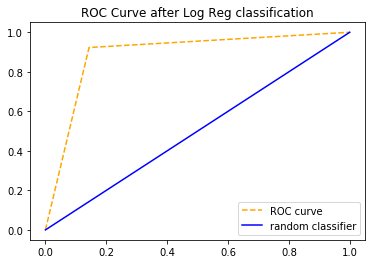

In [5]:
# plotting roc curve
fpr, tpr, thresholds = roc_curve(y_le_test, y_pred)
plt.title('ROC Curve after Log Reg classification')
plt.plot(fpr, tpr, color='orange', linestyle='--', label='ROC curve');
plt.plot([0, 1], [0, 1], color='blue', label='random classifier');
plt.legend();

In [6]:
# Train using random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train, y_le_train)

y_Pred = rf.predict(x_test)

In [7]:
report = classification_report(y_le_test, y_Pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.69      0.76       272
           1       0.74      0.88      0.80       272

    accuracy                           0.78       544
   macro avg       0.80      0.78      0.78       544
weighted avg       0.80      0.78      0.78       544



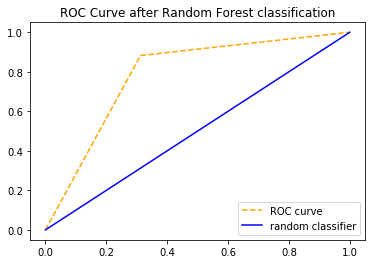

In [8]:
# plotting roc curve
fpr, tpr, thresholds = roc_curve(y_le_test, y_Pred)
plt.title('ROC Curve after Random Forest classification')
plt.plot(fpr, tpr, color='orange', linestyle='--', label='ROC curve');
plt.plot([0, 1], [0, 1], color='blue', label='random classifier');
plt.legend();

In [9]:
# define hyperparameter space
param_grid = {
    'lr': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'l2_lambda': list(np.linspace(0, 1)),
    'dropout_rate': list(np.linspace(0,1))
}


In [10]:
# grid search to get best hyperparameters
param_result = train.random_search(x_val, y_val, param_grid=param_grid)

  0%|          | 0/12 [00:00<?, ?it/s]

training with params: {'lr': 0.2683488472770238, 'l2_lambda': 0.4897959183673469, 'dropout_rate': 0.9795918367346939}

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch: 00, loss: 0.709
epoch: 01, loss: 0.709
epoch: 02, loss: 0.709
epoch: 03, loss: 0.709
epoch: 04, loss: 0.709
epoch: 05, loss: 0.709
epoch: 06, loss: 0.709
epoch: 07, loss: 0.709
epoch: 08, loss: 0.709
epoch: 09, loss: 0.709


  8%|▊         | 1/12 [00:00<00:02,  4.42it/s]

training with params: {'lr': 0.33326816340624565, 'l2_lambda': 0.5306122448979591, 'dropout_rate': 0.04081632653061224}

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch: 00, loss: 0.710
epoch: 01, loss: 0.710
epoch: 02, loss: 0.710
epoch: 03, loss: 0.710
epoch: 04, loss: 0.710
epoch: 05, loss: 0.710
epoch: 06, loss: 0.710
epoch: 07, loss: 0.710
epoch: 08, loss: 0.710
epoch: 09, loss: 0.710


 17%|█▋        | 2/12 [00:00<00:02,  4.69it/s]

training with params: {'lr': 0.016962916913704967, 'l2_lambda': 0.6530612244897959, 'dropout_rate': 0.6326530612244897}

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch: 00, loss: 0.688
epoch: 01, loss: 0.688
epoch: 02, loss: 0.688
epoch: 03, loss: 0.688
epoch: 04, loss: 0.688
epoch: 05, loss: 0.688
epoch: 06, loss: 0.688
epoch: 07, loss: 0.688
epoch: 08, loss: 0.688
epoch: 09, loss: 0.688


 25%|██▌       | 3/12 [00:00<00:01,  4.95it/s]

training with params: {'lr': 0.033713111208891706, 'l2_lambda': 0.3877551020408163, 'dropout_rate': 0.6122448979591836}

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch: 00, loss: 0.700
epoch: 01, loss: 0.700
epoch: 02, loss: 0.700
epoch: 03, loss: 0.700
epoch: 04, loss: 0.700
epoch: 05, loss: 0.700
epoch: 06, loss: 0.700
epoch: 07, loss: 0.700
epoch: 08, loss: 0.700
epoch: 09, loss: 0.700


 33%|███▎      | 4/12 [00:00<00:01,  4.87it/s]

training with params: {'lr': 0.027021082103529572, 'l2_lambda': 0.7551020408163265, 'dropout_rate': 0.26530612244897955}

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch: 00, loss: 0.695
epoch: 01, loss: 0.695
epoch: 02, loss: 0.695
epoch: 03, loss: 0.695
epoch: 04, loss: 0.695
epoch: 05, loss: 0.695
epoch: 06, loss: 0.695
epoch: 07, loss: 0.695
epoch: 08, loss: 0.695
epoch: 09, loss: 0.695


 42%|████▏     | 5/12 [00:01<00:01,  4.33it/s]

training with params: {'lr': 0.0539514395758092, 'l2_lambda': 0.16326530612244897, 'dropout_rate': 0.36734693877551017}

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch: 00, loss: 0.703
epoch: 01, loss: 0.703
epoch: 02, loss: 0.703
epoch: 03, loss: 0.703
epoch: 04, loss: 0.703
epoch: 05, loss: 0.703
epoch: 06, loss: 0.703
epoch: 07, loss: 0.703
epoch: 08, loss: 0.703
epoch: 09, loss: 0.703


 50%|█████     | 6/12 [00:01<00:01,  4.69it/s]

training with params: {'lr': 0.009666211437775225, 'l2_lambda': 0.9795918367346939, 'dropout_rate': 0.12244897959183673}

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch: 00, loss: 0.715
epoch: 01, loss: 0.715
epoch: 02, loss: 0.715
epoch: 03, loss: 0.715
epoch: 04, loss: 0.715
epoch: 05, loss: 0.715
epoch: 06, loss: 0.715
epoch: 07, loss: 0.715
epoch: 08, loss: 0.715
epoch: 09, loss: 0.715


 58%|█████▊    | 7/12 [00:01<00:00,  5.06it/s]

training with params: {'lr': 0.0925203509771151, 'l2_lambda': 0.32653061224489793, 'dropout_rate': 0.6938775510204082}

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch: 00, loss: 0.701
epoch: 01, loss: 0.701
epoch: 02, loss: 0.701
epoch: 03, loss: 0.701
epoch: 04, loss: 0.701
epoch: 05, loss: 0.701
epoch: 06, loss: 0.701
epoch: 07, loss: 0.701
epoch: 08, loss: 0.701
epoch: 09, loss: 0.701


 67%|██████▋   | 8/12 [00:01<00:00,  5.25it/s]

training with params: {'lr': 0.13944901461902204, 'l2_lambda': 0.7755102040816326, 'dropout_rate': 0.18367346938775508}

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch: 00, loss: 0.711
epoch: 01, loss: 0.711
epoch: 02, loss: 0.711
epoch: 03, loss: 0.711
epoch: 04, loss: 0.711
epoch: 05, loss: 0.711
epoch: 06, loss: 0.711
epoch: 07, loss: 0.711
epoch: 08, loss: 0.711
epoch: 09, loss: 0.711


 75%|███████▌  | 9/12 [00:01<00:00,  4.93it/s]

training with params: {'lr': 0.02155780995159114, 'l2_lambda': 0.12244897959183673, 'dropout_rate': 0.9387755102040816}

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch: 00, loss: 0.733
epoch: 01, loss: 0.733
epoch: 02, loss: 0.733
epoch: 03, loss: 0.733
epoch: 04, loss: 0.733
epoch: 05, loss: 0.733
epoch: 06, loss: 0.733
epoch: 07, loss: 0.733
epoch: 08, loss: 0.733
epoch: 09, loss: 0.733


 83%|████████▎ | 10/12 [00:02<00:00,  5.12it/s]

training with params: {'lr': 0.007065129952997668, 'l2_lambda': 0.8775510204081632, 'dropout_rate': 0.42857142857142855}

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch: 00, loss: 0.693
epoch: 01, loss: 0.693
epoch: 02, loss: 0.693
epoch: 03, loss: 0.693
epoch: 04, loss: 0.693
epoch: 05, loss: 0.693
epoch: 06, loss: 0.693
epoch: 07, loss: 0.693
epoch: 08, loss: 0.693
epoch: 09, loss: 0.693


 92%|█████████▏| 11/12 [00:02<00:00,  5.21it/s]

training with params: {'lr': 0.046337966505734386, 'l2_lambda': 0.7142857142857142, 'dropout_rate': 0.12244897959183673}

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch: 00, loss: 0.683
epoch: 01, loss: 0.683
epoch: 02, loss: 0.683
epoch: 03, loss: 0.683
epoch: 04, loss: 0.683
epoch: 05, loss: 0.683
epoch: 06, loss: 0.683
epoch: 07, loss: 0.683
epoch: 08, loss: 0.683
epoch: 09, loss: 0.683


100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


In [11]:
# visualize hyperparams
sorted_param_res = sorted(param_result, key=lambda x: x[1])
hp = sorted_param_res[0][0]

In [12]:
# train on best hyper-parameters, based on random search
model_dir = f"models/l2_{hp['l2_lambda']}_lr_{hp['lr']}_dr_{hp['dropout_rate']}"
NUM_EPOCHS = 50
BATCH_SIZE = 256
train.training(x_train, y_train, x_val, y_val, hp, 
               NUM_EPOCHS, BATCH_SIZE, stop_count=5,
              model_dir=model_dir)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch: 00, loss: 0.751
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/l2_0.7142857142857142_lr_0.046337966505734386_dr_0.12244897959183673/assets
epoch: 01, loss: 0.678
INFO:tensorflow:Assets written to: models/l2_0.7142857142857142_lr_0.046337966505734386_dr_0.12244897959183673/assets
epoch: 02, loss: 0.683
epoch: 03, loss: 0.688
epoch: 04, loss: 0.691
epoch: 05, loss: 0.692
epoch: 06, loss: 0.693
epoch: 07, loss: 0.693
epoch: 

<tf.Tensor: shape=(), dtype=float32, numpy=0.67750984>

### Test model on test_set

In [13]:
def accuracy(y_true, y_pred, ix):
    ''' Computes accuracy '''
    y_true_ix = y_true[:,ix]
    y_pred_ix = y_pred[:,ix]
    acc = tf.keras.metrics.Accuracy()
    acc.update_state(y_true_ix, y_pred_ix)
    return acc.result().numpy()


def precision(y_true, y_pred, ix):
    ''' Computes precision '''
    y_true_ix = y_true[:,ix]
    y_pred_ix = y_pred[:,ix]
    prec = tf.keras.metrics.Precision()
    prec.update_state(y_true_ix, y_pred_ix)
    return prec.result().numpy()


def recall(y_true, y_pred, ix):
    ''' Computes recall'''
    y_true_ix = y_true[:,ix]
    y_pred_ix = y_pred[:,ix]
    rec = tf.keras.metrics.Recall()
    rec.update_state(y_true_ix, y_pred_ix)
    return rec.result().numpy()


def auc(y_true, y_pred, ix):
    ''' Computes area under roc curve'''
    y_true_ix = y_true[:,ix]
    y_pred_ix = y_pred[:,ix]
    auroc = tf.keras.metrics.AUC()
    auroc.update_state(y_true_ix, y_pred_ix)
    return auroc.result().numpy()

In [14]:
model_dir = f"models/l2_{hp['l2_lambda']}_lr_{hp['lr']}_dr_{hp['dropout_rate']}"
y_pred = train.predict(x_test, model_dir)

In [15]:
y_pred_oh = train.predict_one_hot(x_test, model_dir)

In [16]:
bg_ix, fg_ix = 0, 1
print(f'bg accuracy: {accuracy(y_test, y_pred_oh, bg_ix)}')
print(f'fg accuracy: {accuracy(y_test, y_pred_oh, fg_ix)}')

bg accuracy: 0.7150735259056091
fg accuracy: 0.7150735259056091


In [17]:
print(f'bg precision: {precision(y_test, y_pred_oh, bg_ix)}')
print(f'fg precision: {precision(y_test, y_pred_oh, fg_ix)}')

bg precision: 0.6543535590171814
fg precision: 0.8545454740524292


In [18]:
print(f'bg recall: {recall(y_test, y_pred_oh, bg_ix)}')
print(f'fg recall: {recall(y_test, y_pred_oh, fg_ix)}')

bg recall: 0.9117646813392639
fg recall: 0.5183823704719543


In [19]:
print(f'bg auc: {auc(y_test, y_pred, bg_ix)}')
print(f'fg auc: {auc(y_test, y_pred, fg_ix)}')

bg auc: 0.7883461117744446
fg auc: 0.7883461713790894


In [20]:
y_test_int = y_test[:,1].numpy()
y_pred_int = y_pred[:,1]
y_oh_int = y_pred_oh[:,1]

              precision    recall  f1-score   support

         0.0       0.65      0.91      0.76       272
         1.0       0.85      0.52      0.65       272

    accuracy                           0.72       544
   macro avg       0.75      0.72      0.70       544
weighted avg       0.75      0.72      0.70       544



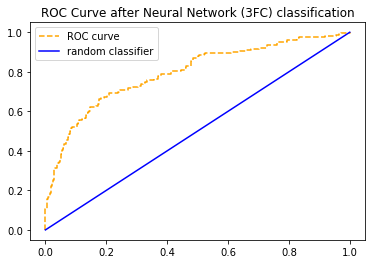

In [21]:
# get classification report and roc curve
y_test_int = y_test[:,1].numpy()
y_pred_int = y_pred[:,1]

report = classification_report(y_test_int, y_oh_int)
print(report)

# plotting roc curve
fpr, tpr, thresholds = roc_curve(y_test_int, y_pred_int)
plt.title('ROC Curve after Neural Network (3FC) classification')
plt.plot(fpr, tpr, color='orange', linestyle='--', label='ROC curve');
plt.plot([0, 1], [0, 1], color='blue', label='random classifier');
plt.legend();

**Results & Observations:**
- First model: everything's getting classified as background

### Test model on test images, visualize

In [22]:
test_images = labels_test.image.unique()
len(test_images)

43

In [27]:
load_raman = False
if load_raman:
    raman_specs = []
    for file in tqdm(test_images):
        try: raman_vec = np.genfromtxt(f'data/raman/{file}.dat', delimiter=',', dtype=None)
        except: continue
        print(f'{file} loaded')
        raman_specs.append([file, raman_vec])

D12_Pos14 loaded
D8.5_Pos1 loaded
D11.5_Pos6 loaded
D12_Pos18 loaded
D12.5_Pos17 loaded
D9_Pos19 loaded
D9.5_Pos17 loaded
D11.5_Pos7 loaded
D10_Pos12 loaded
D12_Pos13 loaded
D10.5_Pos18 loaded
D13_Pos16 loaded
D9_Pos4 loaded
D9_Pos8 loaded
D10_Pos19 loaded
D9.5_Pos3 loaded
D13_Pos11 loaded
D12_Pos7 loaded
D8.5_Pos6 loaded
D9.5_Pos8 loaded
D12.5_Pos10 loaded
D11_Pos2 loaded
D11.5_Pos19 loaded
D11_Pos5 loaded
D9.5_Pos10 loaded
D10.5_Pos8 loaded
D12_Pos1 loaded
D10_Pos4 loaded
D13_Pos6 loaded
D9_Pos12 loaded
D11.5_Pos12 loaded
D12.5_Pos1 loaded
D10.5_Pos19 loaded
D10.5_Pos14 loaded
D10_Pos8 loaded
D11_Pos17 loaded
D11.5_Pos15 loaded
D12_Pos0 loaded
D11.5_Pos14 loaded



In [284]:
# TODO: Save and load Raman specs as a datatype that's easier to read in (because .dat takes FOREVER)
test_images_from_dat = pd.HDFStore('test_images.h5')
# test_images_from_dat['dat_files']
for name, image in raman_specs:
    if '.' in name:
        name = name.replace('.', '')
#     name, image = tup[0], tup[1]
    print(name)
    test_images_from_dat[name] = pd.DataFrame(image)
test_images_from_dat.close()

D12_Pos14
D85_Pos1
D115_Pos6
D12_Pos18
D125_Pos17
D9_Pos19
D95_Pos17
D115_Pos7
D10_Pos12
D12_Pos13
D105_Pos18
D13_Pos16
D9_Pos4
D9_Pos8
D10_Pos19
D95_Pos3
D13_Pos11
D12_Pos7
D85_Pos6
D95_Pos8
D125_Pos10
D11_Pos2
D115_Pos19
D11_Pos5
D95_Pos10
D105_Pos8
D12_Pos1
D10_Pos4
D13_Pos6
D9_Pos12
D115_Pos12
D125_Pos1
D105_Pos19
D105_Pos14
D10_Pos8
D11_Pos17
D115_Pos15
D12_Pos0
D115_Pos14


In [285]:
# try saving as a pkl file
utils.write_zipped_pickle(raman_specs, 'test_images.pkl')

In [274]:
# save test image names
utils.write_zipped_pickle(test_images, 'test_image_names.pkl')

## Show images of predicted foreground probabilities

In [28]:
# helper functions
def predict_image_labels(model, image_vec):
    y_pred = model.predict(image_vec)
    return y_pred

def create_image(y_pred, shape=(100,100)):
    if len(y_pred.shape)>1:
        probs = y_pred[:,1]
    else: probs = y_pred
    image = np.reshape(probs, shape)
    return image

def rotate_image_180(image):
    ''' rotate an image by 180 degrees '''
    return np.rot90(image,2,(0,1))

In [117]:
# get a random image and run through the pre-processing pipeline
image_ix = np.random.randint(0, high=len(raman_specs))
print(f'image {image_ix}: {raman_specs[image_ix][0]}')
image_vec = raman_specs[image_ix][1]

image_fp = pp.get_fingerprint_region(image_vec, start_ix=410)
print('finger-print region extracted')
image_or = pp.remove_sharp_peaks_2d_iter(image_fp, win_size=10, threshold=5)
print('sharp peaks removed')
image_fr = pp.remove_fluorescence(image_or, method='als')
print('fluorescence removed')

image 3: D12_Pos18
finger-print region extracted
sharp peaks removed
fluorescence removed


In [118]:
image_hz = image_fr - np.mean(image_fr, axis=1, keepdims=True)
print('horizontal mean subtracted')
image_ss = StandardScaler().fit_transform(image_hz)
print('cell complete')

horizontal mean subtracted
cell complete


In [119]:
# Predict using NN model

# NN
model_dir = f"models/l2_{hp['l2_lambda']}_lr_{hp['lr']}_dr_{hp['dropout_rate']}"
nn_model = K.models.load_model(model_dir)

y_pred_nn = predict_image_labels(nn_model, image_ss)
nn_image = create_image(y_pred_nn)
nn_image_rot = rotate_image_180(nn_image)

In [120]:
# get ground truth and nucleaize's best segmentation
nuclei_stain_image = plt.imread(f'./data/nuclei_stain/{raman_specs[image_ix][0]}.tif')
segmentation_image = plt.imread(f'./data/labelled/{raman_specs[image_ix][0]}.tiff')

# get window of interest from these images
temp_loc = (368,355)
temp_dims = 1312
nuclei_stain_image_cropped = nuclei_stain_image[temp_loc[0]:temp_loc[0]+temp_dims,temp_loc[1]:temp_loc[1]+temp_dims]
segmentation_image_cropped = segmentation_image[temp_loc[0]:temp_loc[0]+temp_dims,temp_loc[1]:temp_loc[1]+temp_dims]

# get title
image_name = raman_specs[image_ix][0]

In [123]:
from matplotlib import colors as cm

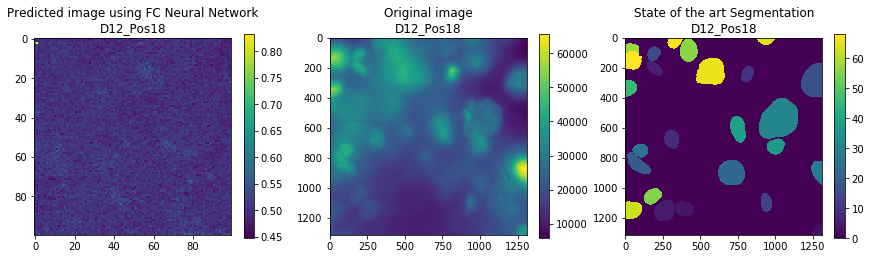

In [124]:
# plot image side by side with original image
norm = cm.Normalize(vmin=0, vmax=1)
fig, axs = plt.subplots(1, 3,figsize=(15,15))
im1 = axs[0].imshow(nn_image_rot)
axs[0].set_title(f'Predicted image using FC Neural Network\n{image_name}')
im2 = axs[1].imshow(nuclei_stain_image_cropped)
axs[1].set_title(f'Original image\n{image_name}')
im3 = axs[2].imshow(segmentation_image_cropped);
axs[2].set_title(f'State of the art Segmentation\n{image_name}')

# add colorbar
fig.colorbar(im1, ax=axs[0], shrink=.25)
fig.colorbar(im2, ax=axs[1], shrink=.25)
fig.colorbar(im3, ax=axs[2], shrink=.25);

# save figure
plt.savefig(f'results/downSampled/nn_image_{image_ix}');


In [125]:
# Predict using log reg model
y_pred_lr = predict_image_labels(log_reg, image_ss)
lr_image = create_image(y_pred_lr)
lr_image_rot = rotate_image_180(lr_image)

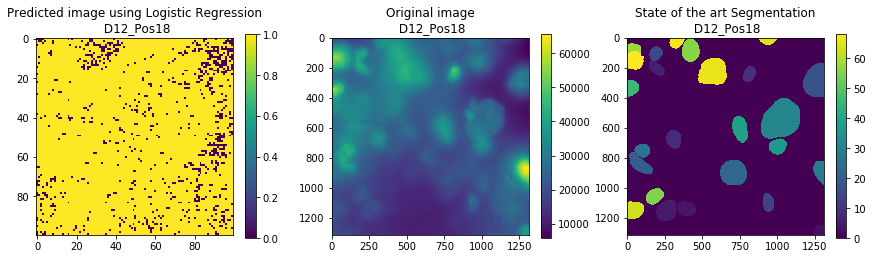

In [126]:
# plot image side by side with original image
fig, axs = plt.subplots(1, 3,figsize=(15,15))
im1 = axs[0].imshow(lr_image_rot)
axs[0].set_title(f'Predicted image using Logistic Regression\n {image_name}')
im2 = axs[1].imshow(nuclei_stain_image_cropped)
axs[1].set_title(f'Original image\n {image_name}')
im3= axs[2].imshow(segmentation_image_cropped);
axs[2].set_title(f'State of the art Segmentation\n {image_name}');

# add colorbar
fig.colorbar(im1, ax=axs[0], shrink=.25)
fig.colorbar(im2, ax=axs[1], shrink=.25)
fig.colorbar(im3, ax=axs[2], shrink=.25);

# save figure
plt.savefig(f'results/downSampled/log_reg_image_{image_ix}')


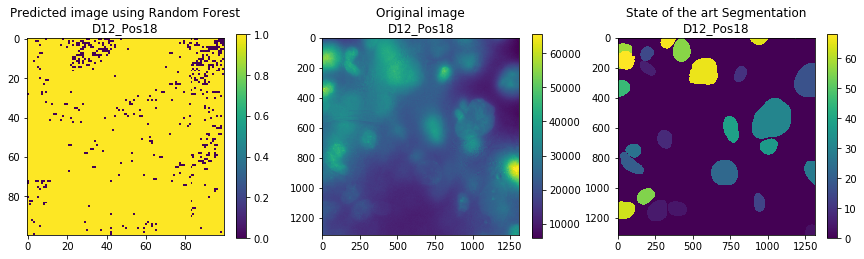

In [127]:
# Predict using random forest model
y_pred_rf = predict_image_labels(rf, image_ss)
rf_image = create_image(y_pred_rf)
rf_image_rot = rotate_image_180(rf_image)

# plot image side by side with original image
fig, axs = plt.subplots(1, 3,figsize=(15,15))
im1 = axs[0].imshow(rf_image_rot)
axs[0].set_title(f'Predicted image using Random Forest\n{image_name}')
im2 = axs[1].imshow(nuclei_stain_image_cropped)
axs[1].set_title(f'Original image\n{image_name}')
im3 = axs[2].imshow(segmentation_image_cropped);
axs[2].set_title(f'State of the art Segmentation\n{image_name}');

# add colorbar
fig.colorbar(im1, ax=axs[0], shrink=.25)
fig.colorbar(im2, ax=axs[1], shrink=.25)
fig.colorbar(im3, ax=axs[2], shrink=.25)

plt.savefig(f'results/downSampled/rf_image_{image_ix}')


### Attempting cell segmentation using K-means clustering

In [245]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [247]:
x_train_sc = scale(x_train)

In [248]:
x_train_out_removed = np.vstack([x_train_sc[:127], x_train_sc[128:]])

In [249]:
reduced_img = PCA(n_components=10).fit_transform(x_train_out_removed)

In [250]:
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)

In [251]:
kmeans.fit(reduced_img)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [254]:
np.where(kmeans.labels_ == 1)

(array([267]),)

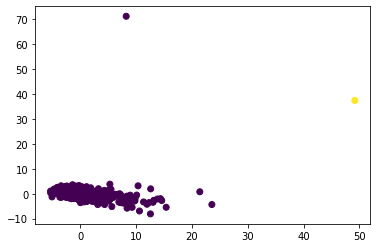

In [253]:
plt.scatter(reduced_train[:,0], reduced_train[:,1], c=kmeans.labels_);

In [190]:
np.where(kmeans.labels_ == 0)

(array([127]),)

In [224]:
# Quickly using FFT
from scipy.fftpack import fft, ifft
fft_train = fft(x_train_np)